# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


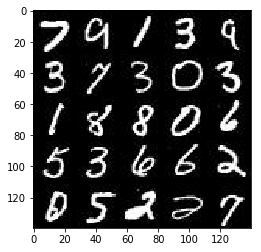

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

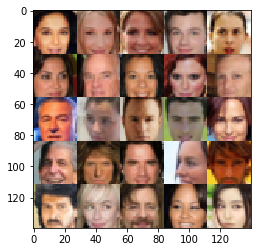

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, dropout=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    # Added as per code review
    keep_prob = tf.constant(dropout)
    kernel_init = tf.contrib.layers.xavier_initializer(seed=29)
            
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x no_of_input_channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob)
        # 14x14x64
        #print("layer shape: ".format(x1.shape))
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob)
        # 7x7x128
        #print("layer shape: ".format(x2.shape))
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob)
        # 4x4x256
        #print("layer shape: ".format(x3.shape))

        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        #print("layer shape: ".format(flat.shape))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, dropout=0.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    
    # Added as per code review
    kernel_init = tf.contrib.layers.xavier_initializer(seed=29)
    keep_prob = tf.constant(dropout)
        
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        x2 = tf.reshape(x1, (-1, 4, 4, 512))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        drop2 = tf.nn.dropout(x2, keep_prob)
        # 4x4x512 now
        #print("Convolutional shape: {}".format(x1.shape))
        
  
        x3 = tf.layers.conv2d_transpose(drop2, 256, 4, strides=1, padding='valid', kernel_initializer=kernel_init)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        drop3 = tf.nn.dropout(x3, keep_prob)
        # 7x7x256
        #print("Convolutional shape: {}".format(x3.shape))
        
        x4 = tf.layers.conv2d_transpose(drop3, 128, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        drop4 = tf.nn.dropout(x4, keep_prob)
        # 14x14x128 now
        #print("Convolutional shape: {}".format(x4.shape))
                  
        # Output layer
        logits = tf.layers.conv2d_transpose(drop4, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        # 28x28xout_channel_dim now
        #print("Convolutional shape: {}".format(logits.shape))
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every=10
    show_every=100
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 1.2381
Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 1.3858
Epoch 1/2... Discriminator Loss: 0.7594... Generator Loss: 1.2412
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 1.0534
Epoch 1/2... Discriminator Loss: 0.7482... Generator Loss: 1.3944
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 1.0235
Epoch 1/2... Discriminator Loss: 0.9099... Generator Loss: 1.5072
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 1.1786
Epoch 1/2... Discriminator Loss: 0.7828... Generator Loss: 1.8182
Epoch 1/2... Discriminator Loss: 0.5368... Generator Loss: 2.2971


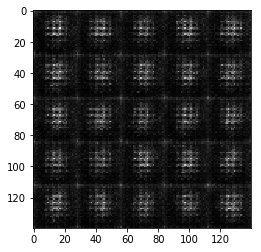

Epoch 1/2... Discriminator Loss: 0.5831... Generator Loss: 1.8596
Epoch 1/2... Discriminator Loss: 0.3978... Generator Loss: 2.2413
Epoch 1/2... Discriminator Loss: 0.3261... Generator Loss: 2.6194
Epoch 1/2... Discriminator Loss: 0.4851... Generator Loss: 1.9829
Epoch 1/2... Discriminator Loss: 0.1733... Generator Loss: 3.3040
Epoch 1/2... Discriminator Loss: 0.1585... Generator Loss: 3.3544
Epoch 1/2... Discriminator Loss: 0.3268... Generator Loss: 2.5950
Epoch 1/2... Discriminator Loss: 0.4294... Generator Loss: 2.6967
Epoch 1/2... Discriminator Loss: 0.2944... Generator Loss: 2.3150
Epoch 1/2... Discriminator Loss: 0.5223... Generator Loss: 2.9214


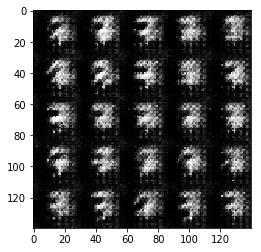

Epoch 1/2... Discriminator Loss: 0.7466... Generator Loss: 2.3231
Epoch 1/2... Discriminator Loss: 0.6344... Generator Loss: 2.3641
Epoch 1/2... Discriminator Loss: 1.1121... Generator Loss: 2.7032
Epoch 1/2... Discriminator Loss: 0.5629... Generator Loss: 2.1797
Epoch 1/2... Discriminator Loss: 0.7101... Generator Loss: 1.9085
Epoch 1/2... Discriminator Loss: 0.3455... Generator Loss: 2.4966
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 3.0119
Epoch 1/2... Discriminator Loss: 0.3465... Generator Loss: 2.4285
Epoch 1/2... Discriminator Loss: 0.6270... Generator Loss: 1.7529
Epoch 1/2... Discriminator Loss: 0.6492... Generator Loss: 2.1495


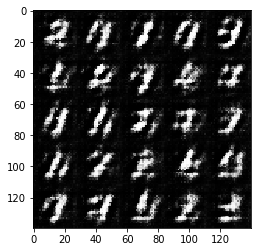

Epoch 1/2... Discriminator Loss: 0.4940... Generator Loss: 2.0784
Epoch 1/2... Discriminator Loss: 0.6695... Generator Loss: 1.7986
Epoch 1/2... Discriminator Loss: 0.6196... Generator Loss: 1.8594
Epoch 1/2... Discriminator Loss: 0.4438... Generator Loss: 2.4293
Epoch 1/2... Discriminator Loss: 0.5144... Generator Loss: 2.2612
Epoch 1/2... Discriminator Loss: 0.7938... Generator Loss: 2.5353
Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 2.2859
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 1.9985
Epoch 1/2... Discriminator Loss: 0.7597... Generator Loss: 1.7620
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.7346


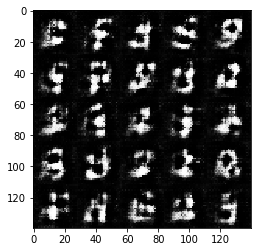

Epoch 1/2... Discriminator Loss: 0.6532... Generator Loss: 1.9369
Epoch 1/2... Discriminator Loss: 0.8025... Generator Loss: 1.4425
Epoch 1/2... Discriminator Loss: 0.6077... Generator Loss: 2.0389
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 1.0131
Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 1.9891
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.0408
Epoch 1/2... Discriminator Loss: 0.5817... Generator Loss: 1.8677
Epoch 1/2... Discriminator Loss: 0.8837... Generator Loss: 1.1920
Epoch 1/2... Discriminator Loss: 0.6836... Generator Loss: 1.7651
Epoch 1/2... Discriminator Loss: 0.6291... Generator Loss: 1.8823


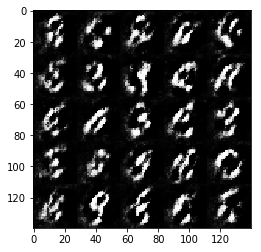

Epoch 1/2... Discriminator Loss: 0.7360... Generator Loss: 1.8948
Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 1.8792
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 1.2523
Epoch 1/2... Discriminator Loss: 0.6693... Generator Loss: 2.0664
Epoch 1/2... Discriminator Loss: 0.8608... Generator Loss: 1.9751
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.5465
Epoch 1/2... Discriminator Loss: 0.7599... Generator Loss: 1.3821
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 1.7060
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 1.4360


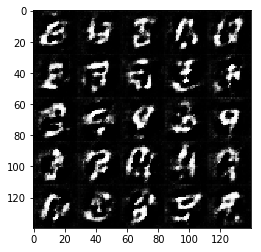

Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 1.5716
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 1.5868
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 1.6784
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 1.7726
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.1445
Epoch 1/2... Discriminator Loss: 0.8109... Generator Loss: 1.2101
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 1.1497
Epoch 1/2... Discriminator Loss: 0.5842... Generator Loss: 1.8907
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 2.0546
Epoch 1/2... Discriminator Loss: 0.6412... Generator Loss: 1.7685


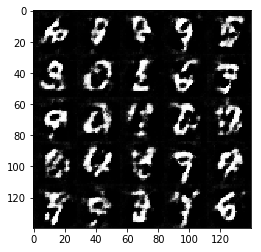

Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 2.1732
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.7127
Epoch 1/2... Discriminator Loss: 0.6554... Generator Loss: 2.0971
Epoch 1/2... Discriminator Loss: 0.8008... Generator Loss: 1.2355
Epoch 1/2... Discriminator Loss: 1.0060... Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 0.7029... Generator Loss: 1.3853
Epoch 1/2... Discriminator Loss: 0.8402... Generator Loss: 2.2886
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 1.4718
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 1.5978
Epoch 1/2... Discriminator Loss: 0.8478... Generator Loss: 2.6386


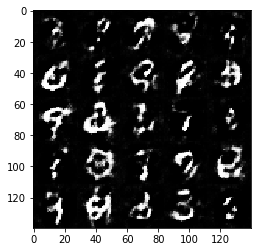

Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 1.9072
Epoch 1/2... Discriminator Loss: 0.5806... Generator Loss: 1.8036
Epoch 1/2... Discriminator Loss: 0.7267... Generator Loss: 1.8117
Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 1.2510
Epoch 1/2... Discriminator Loss: 0.6840... Generator Loss: 2.1518
Epoch 1/2... Discriminator Loss: 0.6207... Generator Loss: 2.0260
Epoch 1/2... Discriminator Loss: 0.6495... Generator Loss: 1.6220
Epoch 1/2... Discriminator Loss: 0.8150... Generator Loss: 2.3960
Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 2.1384
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 1.3415


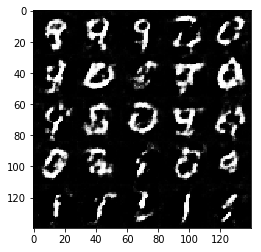

Epoch 1/2... Discriminator Loss: 0.7669... Generator Loss: 1.7120
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.1740
Epoch 1/2... Discriminator Loss: 0.6191... Generator Loss: 1.5578
Epoch 2/2... Discriminator Loss: 0.7248... Generator Loss: 1.5668
Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 2.4131
Epoch 2/2... Discriminator Loss: 0.7008... Generator Loss: 2.6075
Epoch 2/2... Discriminator Loss: 0.6300... Generator Loss: 1.7168
Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 2.4756
Epoch 2/2... Discriminator Loss: 0.7053... Generator Loss: 2.0027
Epoch 2/2... Discriminator Loss: 0.8732... Generator Loss: 1.2318


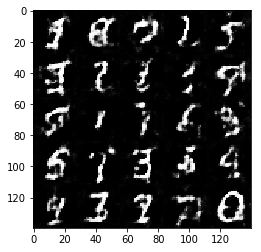

Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.3815
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 2.2057
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 1.4410
Epoch 2/2... Discriminator Loss: 0.7783... Generator Loss: 1.1859
Epoch 2/2... Discriminator Loss: 1.4139... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 1.3520
Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 1.9639
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 2.1836
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.3892
Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.6120


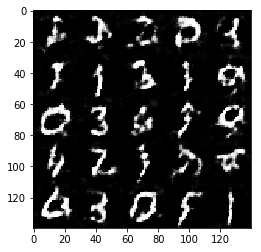

Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 2.2572
Epoch 2/2... Discriminator Loss: 0.8809... Generator Loss: 1.4919
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.5146
Epoch 2/2... Discriminator Loss: 0.8813... Generator Loss: 1.4133
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.4314
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 2.5912
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 1.8321
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 1.0754
Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 0.5734
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 2.0879


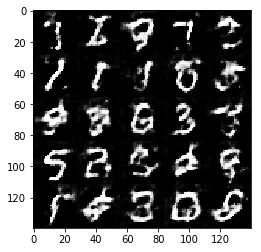

Epoch 2/2... Discriminator Loss: 0.7723... Generator Loss: 1.3252
Epoch 2/2... Discriminator Loss: 0.7777... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 1.1894
Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 2.0199
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 1.1553
Epoch 2/2... Discriminator Loss: 0.7950... Generator Loss: 1.9359
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 2.0752
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 0.9627
Epoch 2/2... Discriminator Loss: 0.9302... Generator Loss: 1.0728


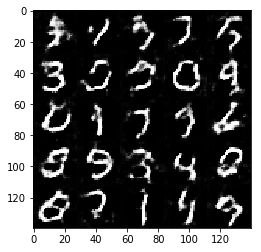

Epoch 2/2... Discriminator Loss: 0.8217... Generator Loss: 1.5895
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.9694
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 1.8154
Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 2.2961
Epoch 2/2... Discriminator Loss: 0.7488... Generator Loss: 1.9252
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 1.2430
Epoch 2/2... Discriminator Loss: 0.7832... Generator Loss: 2.1999
Epoch 2/2... Discriminator Loss: 0.8673... Generator Loss: 1.7105
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 1.3489
Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 1.6892


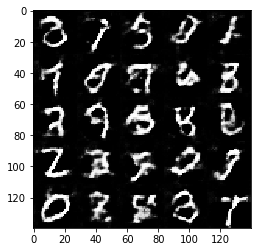

Epoch 2/2... Discriminator Loss: 0.9218... Generator Loss: 1.5253
Epoch 2/2... Discriminator Loss: 0.8121... Generator Loss: 1.6800
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 1.1527... Generator Loss: 0.9409
Epoch 2/2... Discriminator Loss: 1.5433... Generator Loss: 0.5759
Epoch 2/2... Discriminator Loss: 0.7996... Generator Loss: 1.8214
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 1.1411
Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 1.4030
Epoch 2/2... Discriminator Loss: 0.6996... Generator Loss: 1.4441
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 1.1545


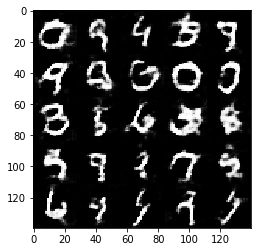

Epoch 2/2... Discriminator Loss: 0.9743... Generator Loss: 1.3276
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 1.2172
Epoch 2/2... Discriminator Loss: 0.8133... Generator Loss: 1.5116
Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 1.1969
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.5904
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 1.7891
Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.3104
Epoch 2/2... Discriminator Loss: 1.0551... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 0.8700... Generator Loss: 1.1840


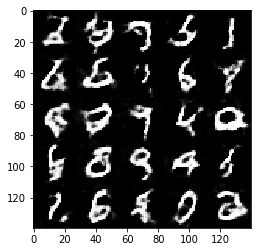

Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 1.1876
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 0.8444
Epoch 2/2... Discriminator Loss: 0.9343... Generator Loss: 1.7587
Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 1.5677
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 0.9264
Epoch 2/2... Discriminator Loss: 0.8980... Generator Loss: 1.8062
Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 2.3309
Epoch 2/2... Discriminator Loss: 0.9419... Generator Loss: 1.1556
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 2.0961


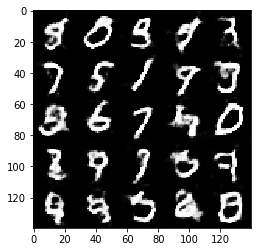

Epoch 2/2... Discriminator Loss: 0.8598... Generator Loss: 1.1116
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 1.4320
Epoch 2/2... Discriminator Loss: 1.0860... Generator Loss: 1.1178
Epoch 2/2... Discriminator Loss: 0.9228... Generator Loss: 1.1732
Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 1.3938
Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 1.1689
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 1.5288
Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 1.0567
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 1.3129
Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 1.9997


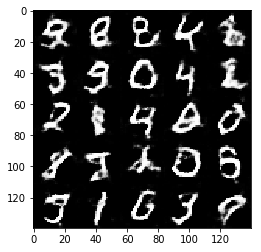

Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 1.7250
Epoch 2/2... Discriminator Loss: 1.0411... Generator Loss: 1.8762
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.8915
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.3946
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.3825
Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 1.5069
Epoch 2/2... Discriminator Loss: 0.7046... Generator Loss: 1.6737


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.5260
Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 1.8395
Epoch 1/1... Discriminator Loss: 0.2717... Generator Loss: 2.5027
Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 2.0963
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 2.4808
Epoch 1/1... Discriminator Loss: 0.2737... Generator Loss: 2.2542
Epoch 1/1... Discriminator Loss: 0.3080... Generator Loss: 2.8433
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 2.8876
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.3835
Epoch 1/1... Discriminator Loss: 0.2758... Generator Loss: 2.5237


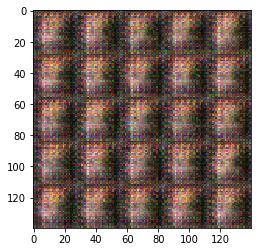

Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 3.1114
Epoch 1/1... Discriminator Loss: 0.1191... Generator Loss: 3.2748
Epoch 1/1... Discriminator Loss: 0.2487... Generator Loss: 2.3079
Epoch 1/1... Discriminator Loss: 0.2649... Generator Loss: 2.3329
Epoch 1/1... Discriminator Loss: 0.1541... Generator Loss: 3.3017
Epoch 1/1... Discriminator Loss: 0.2963... Generator Loss: 1.7809
Epoch 1/1... Discriminator Loss: 0.1492... Generator Loss: 3.7677
Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 3.1934
Epoch 1/1... Discriminator Loss: 0.1520... Generator Loss: 3.4178
Epoch 1/1... Discriminator Loss: 0.1464... Generator Loss: 3.4444


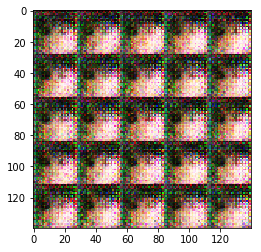

Epoch 1/1... Discriminator Loss: 0.1519... Generator Loss: 3.5493
Epoch 1/1... Discriminator Loss: 0.2255... Generator Loss: 5.2540
Epoch 1/1... Discriminator Loss: 0.2147... Generator Loss: 2.9506
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 7.5367
Epoch 1/1... Discriminator Loss: 0.2349... Generator Loss: 2.6672
Epoch 1/1... Discriminator Loss: 0.2483... Generator Loss: 2.5964
Epoch 1/1... Discriminator Loss: 0.1467... Generator Loss: 3.1191
Epoch 1/1... Discriminator Loss: 0.0866... Generator Loss: 4.2510
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 4.1710
Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 3.5049


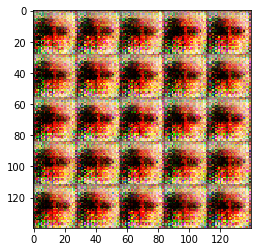

Epoch 1/1... Discriminator Loss: 0.0405... Generator Loss: 4.2976
Epoch 1/1... Discriminator Loss: 0.1167... Generator Loss: 3.2545
Epoch 1/1... Discriminator Loss: 0.0337... Generator Loss: 4.5728
Epoch 1/1... Discriminator Loss: 0.0514... Generator Loss: 3.8506
Epoch 1/1... Discriminator Loss: 0.2511... Generator Loss: 2.0795
Epoch 1/1... Discriminator Loss: 0.1042... Generator Loss: 4.3972
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 4.0989
Epoch 1/1... Discriminator Loss: 0.1306... Generator Loss: 2.7654
Epoch 1/1... Discriminator Loss: 0.0643... Generator Loss: 4.3935
Epoch 1/1... Discriminator Loss: 0.0567... Generator Loss: 4.1678


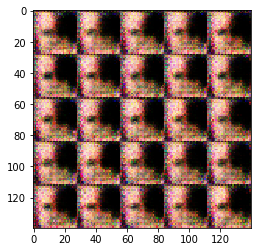

Epoch 1/1... Discriminator Loss: 0.0528... Generator Loss: 4.3005
Epoch 1/1... Discriminator Loss: 0.1012... Generator Loss: 4.2156
Epoch 1/1... Discriminator Loss: 0.1001... Generator Loss: 4.8408
Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 4.0949
Epoch 1/1... Discriminator Loss: 0.0368... Generator Loss: 4.0912
Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 4.1785
Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 4.2310
Epoch 1/1... Discriminator Loss: 0.1467... Generator Loss: 3.3781
Epoch 1/1... Discriminator Loss: 0.0678... Generator Loss: 4.2826
Epoch 1/1... Discriminator Loss: 0.0495... Generator Loss: 4.1442


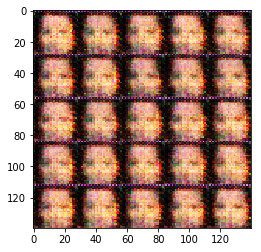

Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 4.2135
Epoch 1/1... Discriminator Loss: 0.0491... Generator Loss: 4.3941
Epoch 1/1... Discriminator Loss: 0.0597... Generator Loss: 4.3806
Epoch 1/1... Discriminator Loss: 0.0315... Generator Loss: 4.5761
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 4.8725
Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 4.1450
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 4.8045
Epoch 1/1... Discriminator Loss: 0.0355... Generator Loss: 4.6655
Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 5.0548
Epoch 1/1... Discriminator Loss: 0.0153... Generator Loss: 5.7042


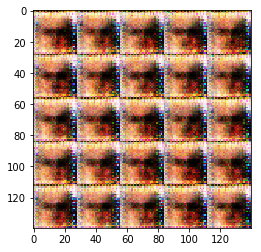

Epoch 1/1... Discriminator Loss: 0.0735... Generator Loss: 4.3385
Epoch 1/1... Discriminator Loss: 0.0430... Generator Loss: 4.3435
Epoch 1/1... Discriminator Loss: 0.0301... Generator Loss: 5.3519
Epoch 1/1... Discriminator Loss: 0.0368... Generator Loss: 4.7917
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 4.5164
Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 5.0660
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 4.2258
Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 4.9558
Epoch 1/1... Discriminator Loss: 0.0338... Generator Loss: 5.3088
Epoch 1/1... Discriminator Loss: 0.0675... Generator Loss: 4.8498


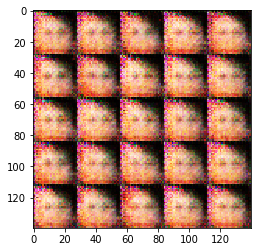

Epoch 1/1... Discriminator Loss: 0.1087... Generator Loss: 6.7782
Epoch 1/1... Discriminator Loss: 0.0524... Generator Loss: 4.4275
Epoch 1/1... Discriminator Loss: 0.0899... Generator Loss: 4.3346
Epoch 1/1... Discriminator Loss: 0.1659... Generator Loss: 3.4863
Epoch 1/1... Discriminator Loss: 0.1743... Generator Loss: 2.8209
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 1.6990
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 6.2278
Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 2.4315
Epoch 1/1... Discriminator Loss: 0.1337... Generator Loss: 2.8092
Epoch 1/1... Discriminator Loss: 0.1246... Generator Loss: 3.2695


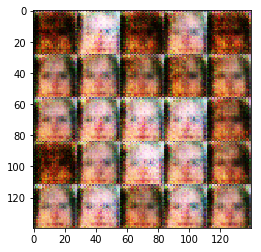

Epoch 1/1... Discriminator Loss: 0.1142... Generator Loss: 4.4280
Epoch 1/1... Discriminator Loss: 0.1763... Generator Loss: 5.0681
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 4.2819
Epoch 1/1... Discriminator Loss: 0.2985... Generator Loss: 2.5237
Epoch 1/1... Discriminator Loss: 0.1626... Generator Loss: 4.8443
Epoch 1/1... Discriminator Loss: 0.0414... Generator Loss: 4.1736
Epoch 1/1... Discriminator Loss: 0.2844... Generator Loss: 3.2519
Epoch 1/1... Discriminator Loss: 0.1576... Generator Loss: 4.4961
Epoch 1/1... Discriminator Loss: 0.1717... Generator Loss: 3.3184
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 3.1871


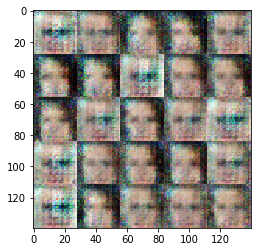

Epoch 1/1... Discriminator Loss: 0.2664... Generator Loss: 3.0847
Epoch 1/1... Discriminator Loss: 0.2640... Generator Loss: 5.2398
Epoch 1/1... Discriminator Loss: 0.2491... Generator Loss: 3.6830
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.6465
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.8199
Epoch 1/1... Discriminator Loss: 0.1958... Generator Loss: 2.6728
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 3.3836
Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 3.2360
Epoch 1/1... Discriminator Loss: 0.2873... Generator Loss: 2.9980


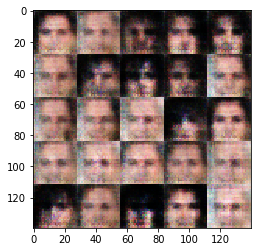

Epoch 1/1... Discriminator Loss: 0.2550... Generator Loss: 3.0301
Epoch 1/1... Discriminator Loss: 0.2854... Generator Loss: 2.1526
Epoch 1/1... Discriminator Loss: 0.1669... Generator Loss: 3.0808
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 2.6204
Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 1.6112
Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 2.3164
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 2.9071
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.5505
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 2.4103
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 2.4510


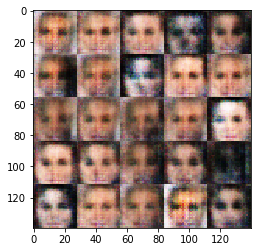

Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 2.4416
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 2.0804
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 2.3351
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 5.0950
Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 2.4560
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 2.8024
Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 1.7993
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 2.4472
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.3888
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 2.5634


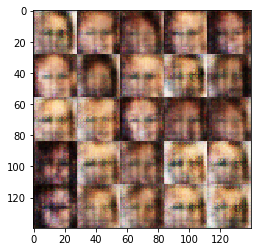

Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 2.1249
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 2.9580
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.6928
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 2.4738
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 2.9029
Epoch 1/1... Discriminator Loss: 0.5635... Generator Loss: 2.7461
Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 2.2801
Epoch 1/1... Discriminator Loss: 0.7207... Generator Loss: 1.4910
Epoch 1/1... Discriminator Loss: 0.5702... Generator Loss: 1.6925


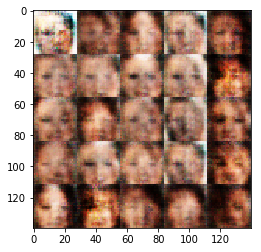

Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 2.7523
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 2.8886
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 2.0692
Epoch 1/1... Discriminator Loss: 0.5109... Generator Loss: 2.6855
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 2.0761
Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.8776
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 3.9000
Epoch 1/1... Discriminator Loss: 0.4471... Generator Loss: 2.7967
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 2.4950
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 2.5250


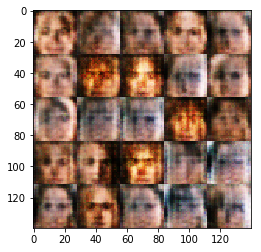

Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 2.3715
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 1.9630
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 2.1599
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 2.8225
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 2.7014
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 2.6381
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.5911
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 2.8082
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.6312
Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 2.1508


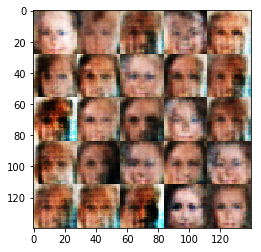

Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.5341
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 2.7414
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 2.5386
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 2.8007
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 2.1346
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 2.1047
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 2.0610
Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 2.1448
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.2306


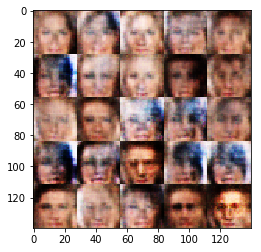

Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.5559
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 2.4599
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.6676
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 2.3682
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 2.8087
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 1.9920
Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 2.2750
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 3.5036
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 2.0898
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 2.1130


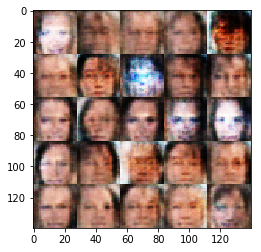

Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 2.7846
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 2.3082
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 2.4982
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 2.0474
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.3191
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.6801
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 1.8259


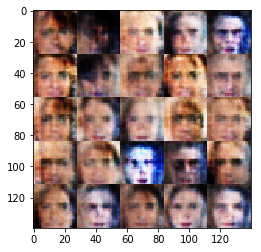

Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.5010
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 2.8693
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 1.6669
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.5101
Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 2.2054
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 2.2386
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.8245
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.8592
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 2.3590
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.6894


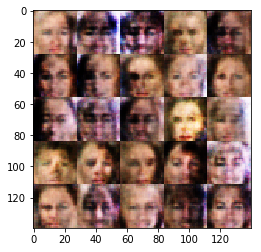

Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.6679
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 1.7139
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 1.9641
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.9692
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 2.0622
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.7325
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.6016
Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 1.8209
Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 1.6099
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.7697


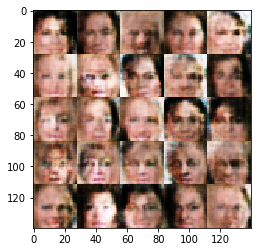

Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.4269
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 2.7449
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 2.0633
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.7916
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.6328
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 2.2533
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.9084
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.6891
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.7154
Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 2.1137


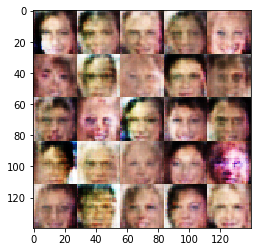

Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 2.2647
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.2231
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.6875
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.5703
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 2.7402
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.7822
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.4736


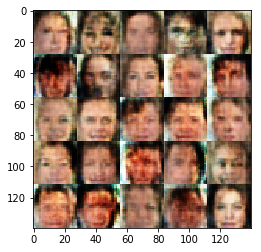

Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.7867
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 1.5704
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 2.0147
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.7165
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.5578
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.6486


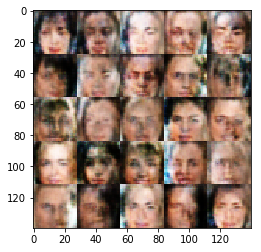

Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.6488
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.3442
Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.5981
Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 1.3936
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.4083
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 2.0904
Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 2.1725
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 1.6447


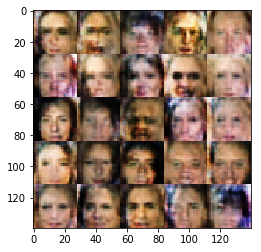

Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 1.7549
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.5970
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.7030
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.2164
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.6197
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.5455
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.9011
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.4535


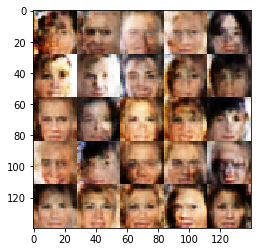

Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.9508
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 0.6977... Generator Loss: 1.4093
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.5996
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 2.0307
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.7913


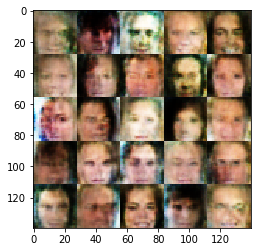

Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.7361
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 1.5255
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.7620
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.5910
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.4801
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.3119
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.3794


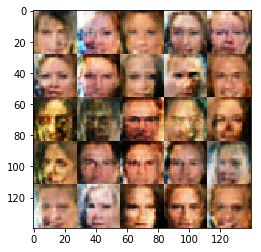

Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.6947
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.5579
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 1.4589
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.9644
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 1.9584
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.5005
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.6837


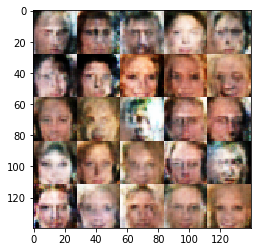

Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.5458
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.4372
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.4937
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.4882
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.5445
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.2971


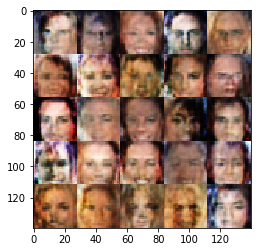

Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 1.6292
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 1.6906
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 1.6109
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.6303
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 1.6818
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.8993


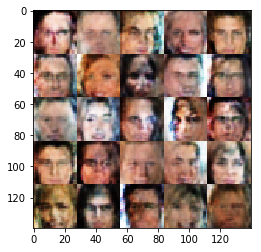

Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.3798
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.7306
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.4961
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.7657
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.8153
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.6281
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.6566
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.9115
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.5848


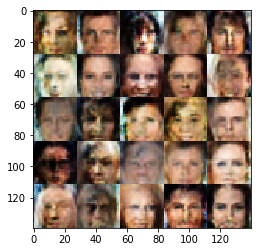

Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 1.8000
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 2.1675
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.4953
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.3867


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.